# Programming Exercise 4: Neural Networks Learning

# Introduction
In this exercise, we will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition. 

# 1 Neural Networks
In the previous exercise, we implemented feedforward propagation for neural networks and used it to predict handwritten digits with predetermined weights. In this exercise, we will implement the backpropagation algorithm to learn the parameters for the neural network.

## 1.1 Visualizing the data
To start, we will load the data and display it on a 2-dimensional plot (Figure 1) by calling the function `displayData`.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.io
import scipy.optimize

In [2]:
def displayData(dataset, row=10, col=10, labels=None, predicted=None, title=None):
    """
    generates a grid image of digits from the MNIST dataset
    """
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(8, 8))
    if title: fig.suptitle(title)
    for r in range(row):
        for c in range(col):
            index = (r+1)*(c+1)-2
            digit = dataset[index].reshape(20, 20).T
            # generate the plot for one image
            axes[r, c].imshow(digit, cmap=plt.cm.binary)
            axes[r, c].axis('off')
            # print the labels
            try: axes[r, c].text(0, 3, str(labels[index]))
            except: pass
            # print the predictions
            try: 
                if predicted[index] == labels[index]:
                    axes[r, c].text(0, 16, str(predicted[index]), color='b')
                else:
                    axes[r, c].text(0, 16, str(predicted[index]), color='r')
            except: pass
    return plt

In [3]:
# Load saved matrices from file
mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
y = mat['y'].T[0]

# In the imported data set, the number zero is labeled as 10. We will change it back to 0
y[np.where(y==10)] = 0

# Setup the parameters you will use for this part of the exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
num_labels = 10          # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

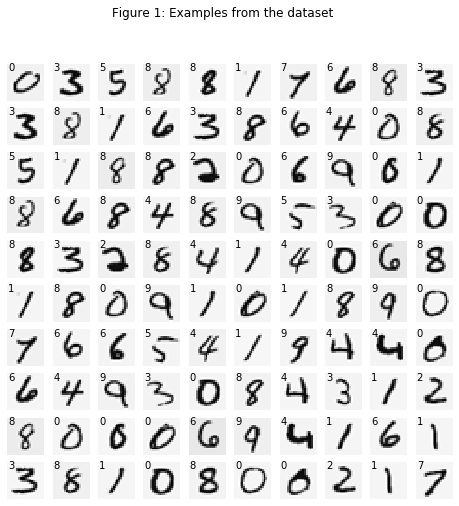

In [4]:
# Randomly select 100 data points to display
m, n = X.shape
rands = np.random.choice(m, 100)

# Display the data
displayData(X[rands], labels=y[rands], title="Figure 1: Examples from the dataset")

This is the same dataset that we used in the previous exercise. There are 5000 training examples in `ex4data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location.

The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

$$ X =
\begin{bmatrix}
    - (x^1)^T - \\   
    - (x^2)^T - \\   
      \vdots    \\
    - (x^m)^T -
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. 

## 1.2 Model representation
Our neural network is shown in Figure 2. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 × 20, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). 

The training data will be loaded into the variables X and y. Pretrained set of network parameters (Θ(1), Θ(2)) are provided. These are stored in `ex4weights.mat` and will be
loaded into Theta1 and Theta2. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

<img src="nn.PNG" alt="Neural Network" width="400">

In [5]:
weights = scipy.io.loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

## 1.3 Feedforward and cost function
Now we will implement the cost function and gradient for the neural network. The code in `CostFunction` will return the cost. Recall that the cost function for the neural network (without regularization) is:

$$J(\theta) = {1 \over m} \sum_{i=1}^m \sum_{k=1}^K [-y^i_k log((h_\theta(x^i))_k) - (1 - y^i_k) log((1 - h_\theta (x^i))_k)]$$

where $h_\theta(x^i)$ is computed as shown in the Figure 2 and K = 10 is the total number of possible labels. Note that $h_\theta(x^i)_k = a^3_k$ is the activation (output value) of the k-th output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, 2, ..., 9, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that:

$y = 
\begin{bmatrix}
    1 \\   
    0 \\   
    \vdots    \\
    0
\end{bmatrix}$, $\quad$
$\begin{bmatrix}
    0 \\   
    1 \\   
    \vdots    \\
    0
\end{bmatrix}$, $\quad$ ... $\quad$
$\begin{bmatrix}
    0 \\   
    0 \\   
    \vdots    \\
    1
\end{bmatrix}$

For example, if x(i) is an image of the digit 5, then the corresponding y(i)(that we should use with the cost function) should be a 10-dimensional vector with y5 = 1, and the other elements equal to 0. 

Note that We implement the feedforward computation that computes hθ(x(i)) for every example i and sum the cost over all examples. The code should work for a dataset of any size, with any number of labels (we can assume that there are always at least K ≥ 3 labels).

The code will call `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`. We should see that the cost is about 0.287629.